## Testing Dataset - Ground Truth Evaluation

This notebook is dedicated to evaluating the ground truth of the dataset from datasets ds_dir.

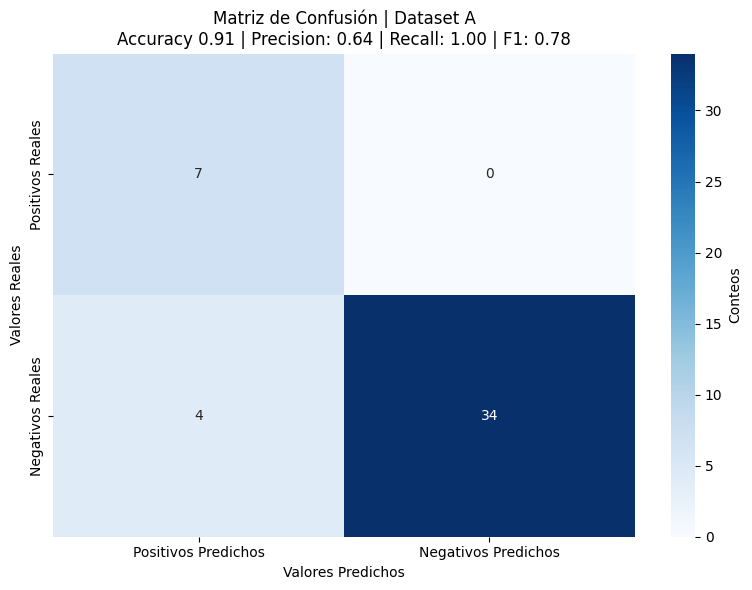

Syntax error in file None line 33:0  LEXER ERROR: inconsistent use of tabs and spaces in indentation
Syntax error in file None line 33:1 no viable alternative at input '\n ERROR: inconsistent use of tabs and spaces in indentation'
Syntax error in file None line 34:1 mismatched input '<INDENT>' expecting <EOF>


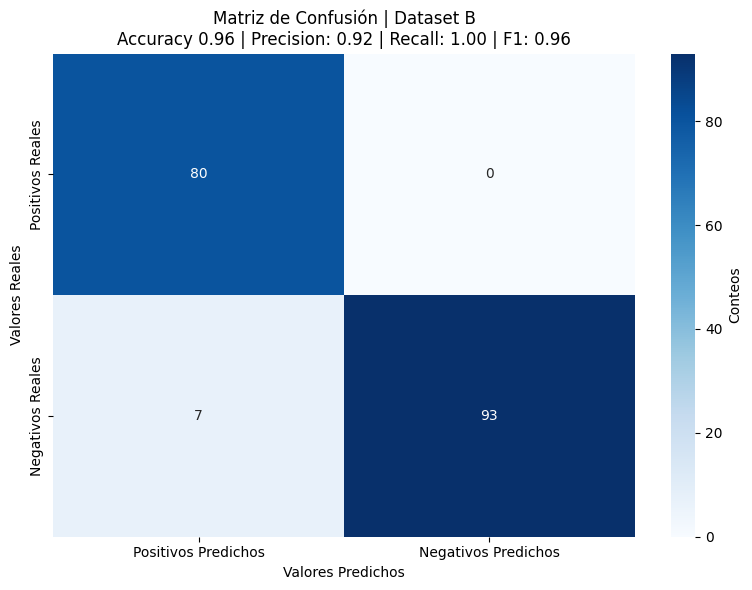

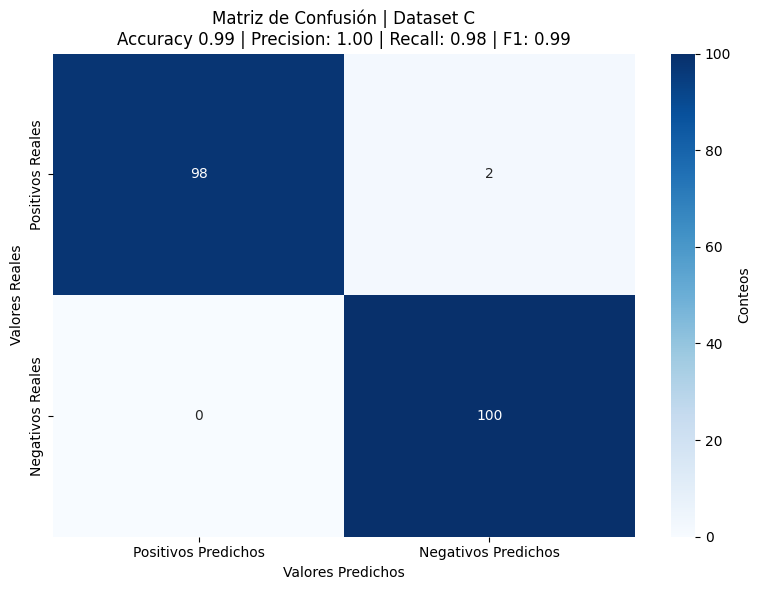

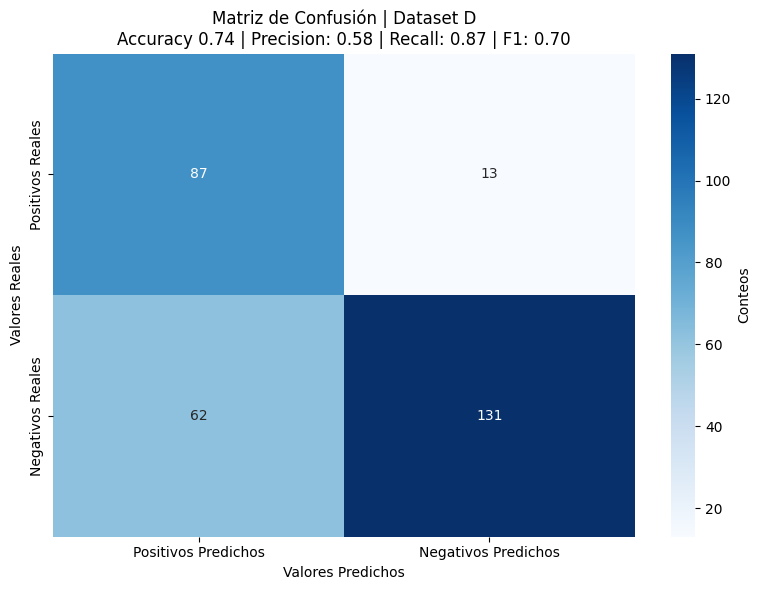

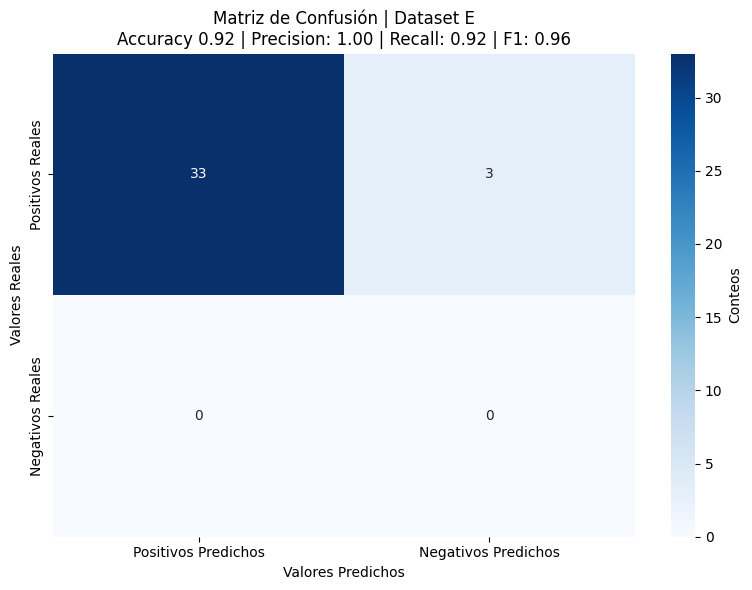

In [9]:
# Import required modules for file processing and comparison
import os
from scsc import Compare
import pandas as pd

files_path = os.path.abspath(os.getcwd())
parent_path = os.path.dirname(files_path)


def get_truth_and_predicted_values(ds_dir, ds_sub_dir, csv_name, method="csim"):
    """
    NOTE:
    Change the csv_path to the location of your dataset if it's different from the default path.
    The dataset should be in the format of a CSV file with columns 'File_1', 'File_2', and 'Label'
    where 'Label' indicates whether the pair of files are similar (1) or not (0).
    """

    csv_path = os.path.join(parent_path, ds_dir, ds_sub_dir, csv_name)

    balanced_df = pd.read_csv(csv_path)

    predicted_values = []
    truth_values = balanced_df["Label"].tolist()
    THRESHOLD = (
        0.70  # Set a threshold for similarity score to classify pairs as similar or not
    )

    def get_content_from_path(path):
        with open(path, "r") as file:
            return file.read()

    for row in balanced_df.itertuples():
        f1_name, f2_name = row.File_1, row.File_2
        f1_path = os.path.join(
            parent_path, ds_dir, ds_sub_dir, f1_name
        )  # Change the path if your files are located in a different ds_dir
        f2_path = os.path.join(
            parent_path, ds_dir, ds_sub_dir, f2_name
        )  # Change the path if your files are located in a different ds_dir

        content1 = get_content_from_path(f1_path)
        content2 = get_content_from_path(f2_path)
        score = Compare(content1, content2, method=method)
        predicted_values.append(1 if score >= THRESHOLD else 0)

    return truth_values, predicted_values


import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)
import seaborn as sns


def calculate_metrics(true_values, predicted_values):
    # Ensure that the labels are ordered as [1, 0] to maintain consistency in the confusion matrix
    matrix = confusion_matrix(true_values, predicted_values, labels=[1, 0])
    accuracy = accuracy_score(true_values, predicted_values)
    precision = precision_score(true_values, predicted_values)
    recall = recall_score(true_values, predicted_values)
    f1 = f1_score(true_values, predicted_values)
    return matrix, accuracy, precision, recall, f1


def plot_confusion_matrix(
    true_values, predicted_values, title=None, normalize=False, show_metrics=True
):

    matrix, accuracy, precision, recall, f1 = calculate_metrics(
        true_values, predicted_values
    )

    # Normalization by true class (row)
    if normalize:
        row_sums = matrix.sum(axis=1, keepdims=True)
        # Avoid division by zero
        row_sums[row_sums == 0] = 1
        display_matrix = matrix.astype(float) / row_sums
        fmt = ".2f"
        cbar_label = "Proporción"
    else:
        display_matrix = matrix
        fmt = "d"
        cbar_label = "Conteos"

    # Result: [[TP, FN], [FP, TN]]
    df_cm = pd.DataFrame(
        display_matrix,
        index=["Positivos Reales", "Negativos Reales"],
        columns=["Positivos Predichos", "Negativos Predichos"],
    )

    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(
        df_cm, annot=True, fmt=fmt, cmap="Blues", cbar_kws={"label": cbar_label}
    )
    plt.xlabel("Valores Predichos")
    plt.ylabel("Valores Reales")

    title = f"Matriz de Confusión | {title}" if title else "Matriz de Confusión"
    if show_metrics:
        title += f"\nAccuracy {accuracy:.2f} | Precision: {precision:.2f} | Recall: {recall:.2f} | F1: {f1:.2f}"
    plt.title(title)
    plt.tight_layout()
    plt.show()

"""
    Small dataset evaluation
"""
small_truth_values, small_predicted_values = get_truth_and_predicted_values(
    ds_dir="datasets",
    ds_sub_dir="small",
    csv_name="small_dataset.csv",
    method="csim",
)
plot_confusion_matrix(
    small_truth_values, small_predicted_values, title='Dataset A', normalize=False, show_metrics=True
)

"""
    Medium dataset evaluation
"""
medium_truth_values, medium_predicted_values = get_truth_and_predicted_values(
    ds_dir="datasets",
    ds_sub_dir="medium",
    csv_name="medium_dataset.csv",
    method="csim",
)
plot_confusion_matrix(
    medium_truth_values, medium_predicted_values, title='Dataset B', normalize=False, show_metrics=True
)

"""
    Large dataset evaluation
"""
large_truth_values, large_predicted_values = get_truth_and_predicted_values(
    ds_dir="datasets",
    ds_sub_dir="large",
    csv_name="large_dataset.csv",
    method="csim",
)
plot_confusion_matrix(
    large_truth_values, large_predicted_values, title='Dataset C', normalize=False, show_metrics=True
)

"""
    Kaggle dataset evaluation
"""
kaggle_truth_values, kaggle_predicted_values = get_truth_and_predicted_values(
    ds_dir="datasets",
    ds_sub_dir="kaggle",
    csv_name="cheating_dataset.csv",
    method="csim",
)
plot_confusion_matrix(
    kaggle_truth_values, kaggle_predicted_values, title='Dataset D', normalize=False, show_metrics=True
)

"""
    Controlled dataset evaluation
"""
controlled_truth_values, controlled_predicted_values = get_truth_and_predicted_values(
    ds_dir="datasets",
    ds_sub_dir="controlled",
    csv_name="controlled_dataset.csv",
    method="csim",
)
plot_confusion_matrix(
    controlled_truth_values, controlled_predicted_values, title='Dataset E', normalize=False, show_metrics=True
)